In [1]:
import torch
from torchvision import transforms
from PIL import Image, ImageDraw
import numpy as np
import json
import os

# Image transformation pipeline (used for both cloth and person images)
image_transform = transforms.Compose([
    transforms.ToTensor(), # Converts PIL Image/NumPy array to PyTorch Tensor (0-255 -> 0.0-1.0, HWC -> CHW)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes to [-1, 1]
])

# Transformation for the final 'shape' and 'one_map' outputs (single channel, [-1, 1])
parse_shape_final_transform = transforms.Compose([
    transforms.ToTensor(), # PIL Image (0-255) to Tensor (0.0-1.0)
    transforms.Normalize((0.5,), (0.5,)) # Normalize single channel to [-1, 1]
])

def preprocess_image(image_path, mask_path, person_image_path, parsing_map_path,
                     keypoints_json_path, fine_width, fine_height, radius):
    # Cloth Image processing (PyTorch) - Intermediate, not returned
    cloth_image_pil = Image.open(image_path).convert('RGB')
    cloth_image_tensor = image_transform(cloth_image_pil)

    # Cloth Mask processing (NumPy then PyTorch) - Intermediate, not returned
    cm_pil = Image.open(mask_path).convert('RGB')
    cm_array = np.array(cm_pil)
    cm_array = (cm_array >= 128).astype(np.float32)
    cm_tensor = torch.from_numpy(cm_array)
    if cm_tensor.dim() == 3:
        cm_tensor.unsqueeze_(0)
    elif cm_tensor.dim() == 2:
         cm_tensor = cm_tensor.unsqueeze(0).unsqueeze(0)

    # Person Image processing (PyTorch) - This is our 'im'
    person_image_pil = Image.open(person_image_path).convert('RGB')
    person_image_tensor = image_transform(person_image_pil)

    # Human Parsing Map Processing (NumPy/PIL then PyTorch)
    im_parse = Image.open(parsing_map_path)
    parse_array = np.array(im_parse)
    parse_shape = (parse_array > 0).astype(np.float32)
    parse_head = ((parse_array == 1) | (parse_array == 2) | \
                  (parse_array == 4) | (parse_array == 13)).astype(np.float32)
    parse_cloth = ((parse_array == 5) | (parse_array == 6) | \
                   (parse_array == 7)).astype(np.float32)

    if parse_shape.ndim > 2 and parse_shape.shape[-1] == 1:
        parse_shape_pil_input = parse_shape.squeeze(-1)
    else:
        parse_shape_pil_input = parse_shape
    parse_shape_pil = Image.fromarray((parse_shape_pil_input * 255).astype(np.uint8))
    
    parse_shape_downsampled = parse_shape_pil.resize((fine_width // 16, fine_height // 16), Image.BILINEAR)
    parse_shape_resized = parse_shape_downsampled.resize((fine_width, fine_height), Image.BILINEAR)
    shape = parse_shape_final_transform(parse_shape_resized)

    phead = torch.from_numpy(parse_head)
    pcm = torch.from_numpy(parse_cloth)
    if phead.ndim == 2:
        phead = phead.unsqueeze(0)
    if pcm.ndim == 2:
        pcm = pcm.unsqueeze(0)

    im_c = person_image_tensor * pcm + (1 - pcm) # Intermediate, not returned
    im_h = person_image_tensor * phead - (1 - phead) # Intermediate

    # Pose Keypoints Processing (JSON, NumPy, PIL drawing, then PyTorch)
    with open(keypoints_json_path, 'r') as f:
        pose_label = json.load(f)
        if 'people' in pose_label and len(pose_label['people']) > 0 and \
           'pose_keypoints_2d' in pose_label['people'][0]:
            pose_data = pose_label['people'][0]['pose_keypoints_2d']
        elif 'people' in pose_label and len(pose_label['people']) > 0 and \
             'pose_keypoints' in pose_label['people'][0]:
            pose_data = pose_label['people'][0]['pose_keypoints']
        else:
            pose_data = []

        pose_data = np.array(pose_data, dtype=np.float32)
        if pose_data.size > 0:
            pose_data = pose_data.reshape((-1, 3))
        else:
            pose_data = np.zeros((0, 3), dtype=np.float32)

    point_num = pose_data.shape[0]
    pose_map = torch.zeros(point_num, fine_height, fine_width, dtype=torch.float32)

    im_pose = Image.new('L', (fine_width, fine_height))
    pose_draw = ImageDraw.Draw(im_pose)

    for i in range(point_num):
        one_map = Image.new('L', (fine_width, fine_height))
        draw = ImageDraw.Draw(one_map)
        pointx = pose_data[i, 0]
        pointy = pose_data[i, 1]

        if pointx > 1 and pointy > 1 and pose_data[i, 2] > 0.1:
            draw.rectangle((pointx - radius, pointy - radius, pointx + radius, pointy + radius), 'white', 'white')
            pose_draw.rectangle((pointx - radius, pointy - radius, pointx + radius, pointy + radius), 'white', 'white')
        
        one_map_tensor = parse_shape_final_transform(one_map)[0]
        pose_map[i] = one_map_tensor

    # Calculate Cloth-Agnostic Representation
    agnostic = torch.cat([shape, im_h, pose_map], 0)

    # Return only the agnostic tensor
    return agnostic

In [5]:
agnostic = preprocess_image(
    '/kaggle/input/high-resolution-viton-zalando-dataset/test/cloth/00006_00.jpg',
    '/kaggle/input/high-resolution-viton-zalando-dataset/test/cloth-mask/00006_00.jpg',
    '/kaggle/input/high-resolution-viton-zalando-dataset/test/image/00006_00.jpg',
    '/kaggle/input/high-resolution-viton-zalando-dataset/test/image-parse-v3/00006_00.png',
    '/kaggle/input/high-resolution-viton-zalando-dataset/test/openpose_json/00006_00_keypoints.json',
    768,
    1024,
    7
)

In [4]:
import matplotlib.pyplot as plt
import torch
import numpy as np # For converting PyTorch tensors to NumPy arrays for visualization

def visualize_agnostic(agnostic_tensor):
    """
    Visualizes the components of the cloth-agnostic representation.

    Args:
        agnostic_tensor (torch.Tensor): The output tensor from preprocess_image,
                                        expected shape (C_total, H, W).
                                        C_total = 1 (shape) + 3 (im_h) + N (pose_map channels)
    """
    if not isinstance(agnostic_tensor, torch.Tensor):
        raise TypeError("Input 'agnostic_tensor' must be a PyTorch Tensor.")
    if agnostic_tensor.ndim != 3:
        raise ValueError(f"Input 'agnostic_tensor' must be 3-dimensional (C, H, W), "
                         f"but got {agnostic_tensor.ndim} dimensions.")

    total_channels = agnostic_tensor.shape[0]
    H, W = agnostic_tensor.shape[1], agnostic_tensor.shape[2]

    # --- Extract Components ---
    # Assuming the concatenation order was [shape, im_h, pose_map]
    
    # 1. Shape: The first channel (1 channel)
    shape_tensor = agnostic_tensor[0:1, :, :] # Keep as (1, H, W)

    # 2. im_h: The next 3 channels (for RGB image)
    im_h_tensor = agnostic_tensor[1:4, :, :] # (3, H, W)
    
    # 3. Pose Map: The remaining channels (N channels)
    pose_map_tensor = agnostic_tensor[4:, :, :] # (N, H, W)
    
    # --- Prepare for Visualization ---
    # Convert PyTorch tensors to NumPy arrays and adjust range/dimensions for Matplotlib

    # im_h: Scale from [-1, 1] to [0, 1] and permute (C, H, W) to (H, W, C)
    im_h_np = im_h_tensor.permute(1, 2, 0).cpu().numpy() # (H, W, C)
    im_h_np = (im_h_np * 0.5) + 0.5 # Scale to [0, 1]

    # shape: Scale from [-1, 1] to [0, 1] and remove channel dim (1, H, W) to (H, W)
    shape_np = shape_tensor.squeeze(0).cpu().numpy() # (H, W)
    shape_np = (shape_np * 0.5) + 0.5 # Scale to [0, 1]

    # Aggregated Pose Map: Sum all individual pose maps if any, scale to [0, 1]
    # This shows where keypoints are located overall
    if pose_map_tensor.shape[0] > 0:
        agg_pose_map_np = pose_map_tensor.sum(dim=0).cpu().numpy() # Sum along channel dim (H, W)
        # Normalize aggregated map to [0, 1] if max value can exceed 1 (due to overlaps)
        if agg_pose_map_np.max() > 0:
            agg_pose_map_np = agg_pose_map_np / agg_pose_map_np.max()
    else:
        agg_pose_map_np = np.zeros((H, W), dtype=np.float32) # Empty map if no keypoints

    # --- Plotting ---
    plt.figure(figsize=(15, 5)) # Adjust figure size as needed

    # Plot im_h
    plt.subplot(1, 3, 1)
    plt.imshow(im_h_np)
    plt.title('Person Image (im_h)')
    plt.axis('off') # Hide axes ticks

    # Plot shape
    plt.subplot(1, 3, 2)
    plt.imshow(shape_np, cmap='gray') # 'gray' colormap for grayscale images
    plt.title('Shape')
    plt.axis('off')

    # Plot Aggregated Pose Map
    plt.subplot(1, 3, 3)
    plt.imshow(agg_pose_map_np, cmap='hot') # 'hot' or 'jet' colormap can show density
    plt.title(f'Aggregated Pose Map ({pose_map_tensor.shape[0]} points)')
    plt.axis('off')

    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show() # Display the plot

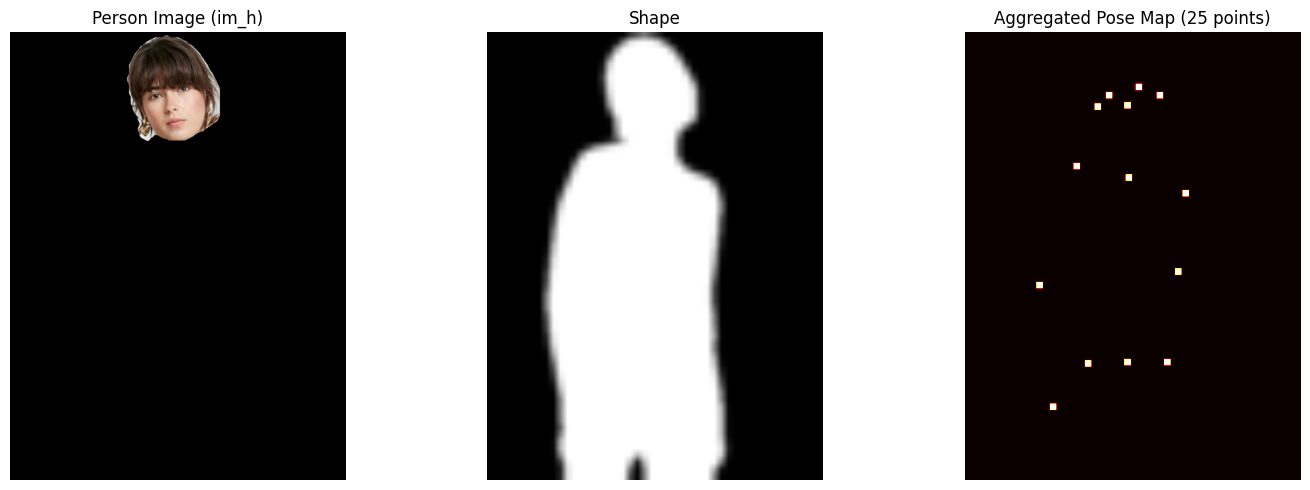

In [6]:
visualize_agnostic(agnostic)